In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
import tqdm
import random

### Preprocessing data

In [2]:
from common import get_data, get_freq_data, get_argmin_distr, signal_cyclic_shift, generate_multi_signal

In [3]:
X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)

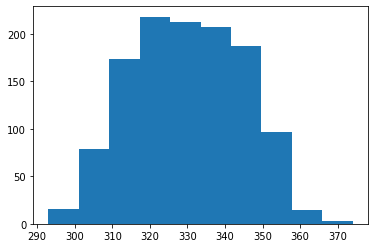

In [4]:
ARGMIN_DISTR = get_argmin_distr(data_path='./data/na62_11_pulses.txt')
plt.hist(ARGMIN_DISTR)
plt.show()

In [5]:
def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False,\
                                                                         start_point=70, end_point=950):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        
        if i < pos_size:
#             X.append(random.choice(X_one_signal))
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)['first_impulse'][start_point:end_point])

            y.append(1)
        else:
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)['multi_impulse'][start_point:end_point])
            y.append(0)
   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [6]:
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_range = np.arange(-25, 25, 1)
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True)

X shape: (5000, 880)
y shape: (5000,)


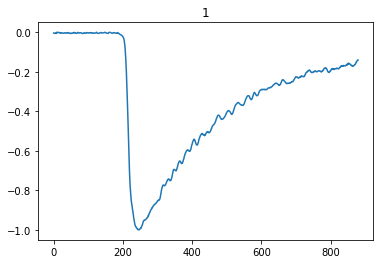

In [7]:
import random
i = random.choice(range(len(X)))
plt.title(str(y[i]))
plt.plot(X[i])
plt.show()

### Models

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

In [9]:
freq_values = [1, 5, 10, 15, 25, 50, 60, 75, 85, 100]

In [10]:
def print_results(iter_num=200):
    global X_freq
    for freq in freq_values:
        X_freq = get_freq_data(X, freq=freq)

        best = fmin(
            fn=f,  # "Loss" function to minimize
            space=space,  # Hyperparameter space
            algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
            max_evals=iter_num  # Perform 100 trials
        )

        print('-----------------------------------------------------')
        print("Freq:", freq)
        print("X_freq shape:", X_freq.shape)
        print("Found minimum after %d trials:" %(iter_num))
        print(best)
        print('-----------------------------------------------------')

### Hyperopt

In [11]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp

###### KNeighborsClassifier

In [12]:
freq_values = [5]

In [27]:
def f(space):
        model = KNeighborsClassifier(n_neighbors=space['n_neighbors'], weights=space['weights'],\
                                     algorithm=space['algorithm'], leaf_size=space['leaf_size'], p=space['p'])
        scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
        return -scores['test_score'].mean()

space = {
        'n_neighbors': ho_scope.int(hp.quniform('n_neighbors', low=2, high=10, q=1)),
        'weights':  hp.choice('weights', ['uniform', 'distance']),
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': ho_scope.int(hp.quniform('leaf_size', low=4, high=60, q=2)),
        'p': hp.choice('p', [1, 2])
}
    
global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [01:10<00:00,  1.41s/it, best loss: -0.49853761660890444]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 50 trials:
{'algorithm': 1, 'leaf_size': 58.0, 'n_neighbors': 2.0, 'p': 1, 'weights': 1}
-----------------------------------------------------


##### DecisionTreeClassifier

In [28]:
def f(space):
    model = DecisionTreeClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [00:24<00:00,  8.00it/s, best loss: -0.5889658735805501]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 14, 'max_features': 0, 'min_samples_leaf': 7.0, 'min_samples_split': 10.0, 'min_weight_fraction_leaf': 0.22130915251484318}
-----------------------------------------------------


##### RandomForest

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
def f(space):
    model = RandomForestClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'],\
                                  verbose=0)
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [03:34<00:00,  1.07s/it, best loss: -0.588599908034393] 
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 18, 'max_features': 0, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'min_weight_fraction_leaf': 0.050722856567138055}
-----------------------------------------------------


##### GaussianNB

In [31]:
def f(space):
    model = GaussianNB(var_smoothing=space['var_smoothing'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'var_smoothing': hp.loguniform('var_smoothing', low=np.log(1e-10), high=np.log(1e-7))
}

global X_freq
print_results()

100%|██████████| 200/200 [00:12<00:00, 16.49it/s, best loss: -0.4258049543236376]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'var_smoothing': 3.466189057096506e-10}
-----------------------------------------------------


##### SVC

In [ ]:
def f(space):
    model = SVC(C=space['C'], kernel=space['kernel'], degree=space['degree'], gamma=space['gamma'],\
               shrinking=space['shrinking'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'degree':  ho_scope.int(hp.quniform('degree', low=2, high=5, q=1)),
    'gamma':  hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'shrinking': hp.choice('shrinking', [True, False])
}

global X_freq
print_results(iter_num=10)

 40%|████      | 4/10 [01:27<02:11, 21.94s/it, best loss: -0.6476958489414046] 

##### PassiveAggressiveClassifier

In [13]:
def f(space):
    model = PassiveAggressiveClassifier(C=space['C'], fit_intercept=space['fit_intercept'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
}

global X_freq
print_results()

  0%|          | 1/200 [00:00<00:31,  6.29it/s, best loss: -0.4447409125908278]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  2%|▏         | 3/200 [00:00<00:30,  6.39it/s, best loss: -0.4447409125908278]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 4/200 [00:00<00:34,  5.75it/s, best loss: -0.4447409125908278]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  3%|▎         | 6/200 [00:00<00:29,  6.47it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▎         | 7/200 [00:01<00:30,  6.38it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▍         | 8/200 [00:01<00:29,  6.46it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  5%|▌         | 10/200 [00:01<00:31,  6.11it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▌         | 12/200 [00:01<00:30,  6.21it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▋         | 13/200 [00:02<00:31,  5.95it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  7%|▋         | 14/200 [00:02<00:29,  6.35it/s, best loss: -0.5299790472498361]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  8%|▊         | 16/200 [00:02<00:31,  5.88it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 17/200 [00:02<00:36,  5.06it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  9%|▉         | 18/200 [00:03<00:32,  5.58it/s, best loss: -0.5299790472498361]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 20/200 [00:03<00:32,  5.52it/s, best loss: -0.5324343736446637]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 11%|█         | 22/200 [00:03<00:36,  4.94it/s, best loss: -0.5324343736446637]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 12%|█▏        | 23/200 [00:03<00:33,  5.22it/s, best loss: -0.5324343736446637]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▎        | 25/200 [00:04<00:31,  5.62it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▎        | 27/200 [00:04<00:29,  5.80it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▍        | 28/200 [00:04<00:30,  5.66it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 15%|█▌        | 30/200 [00:05<00:36,  4.66it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▌        | 31/200 [00:05<00:34,  4.93it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▋        | 33/200 [00:05<00:31,  5.34it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 18%|█▊        | 35/200 [00:06<00:28,  5.71it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 19%|█▉        | 38/200 [00:06<00:29,  5.53it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|█▉        | 39/200 [00:06<00:27,  5.77it/s, best loss: -0.6646650925189743]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 41/200 [00:07<00:25,  6.13it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 43/200 [00:07<00:31,  4.97it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 44/200 [00:07<00:29,  5.21it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:08<00:28,  5.36it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▎       | 47/200 [00:08<00:27,  5.66it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 24%|██▍       | 49/200 [00:08<00:25,  5.91it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▌       | 51/200 [00:09<00:24,  6.03it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▌       | 52/200 [00:09<00:24,  6.10it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 27%|██▋       | 54/200 [00:09<00:25,  5.79it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 55/200 [00:09<00:30,  4.83it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 56/200 [00:10<00:33,  4.35it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 57/200 [00:10<00:29,  4.89it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 30%|██▉       | 59/200 [00:10<00:25,  5.47it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 31%|███       | 62/200 [00:11<00:23,  5.82it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▏      | 63/200 [00:11<00:23,  5.94it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▎      | 65/200 [00:11<00:25,  5.27it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 34%|███▎      | 67/200 [00:12<00:24,  5.39it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 34%|███▍      | 69/200 [00:12<00:25,  5.10it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 35%|███▌      | 70/200 [00:12<00:25,  5.12it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▌      | 72/200 [00:13<00:25,  4.95it/s, best loss: -0.6655918766936326]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 37%|███▋      | 74/200 [00:13<00:22,  5.52it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 38%|███▊      | 75/200 [00:13<00:21,  5.69it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 77/200 [00:13<00:21,  5.76it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 39%|███▉      | 78/200 [00:14<00:20,  5.91it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 80/200 [00:14<00:20,  5.79it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 41%|████      | 82/200 [00:15<00:28,  4.21it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 42%|████▏     | 83/200 [00:15<00:26,  4.46it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 84/200 [00:15<00:23,  4.98it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▎     | 87/200 [00:15<00:20,  5.63it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 44%|████▍     | 88/200 [00:16<00:18,  6.04it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▍     | 89/200 [00:16<00:19,  5.84it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 45%|████▌     | 90/200 [00:16<00:21,  5.06it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▌     | 91/200 [00:16<00:23,  4.68it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▌     | 92/200 [00:16<00:24,  4.44it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 47%|████▋     | 94/200 [00:17<00:20,  5.05it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 95/200 [00:17<00:19,  5.35it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 49%|████▉     | 98/200 [00:18<00:18,  5.50it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 50%|█████     | 100/200 [00:18<00:19,  5.22it/s, best loss: -0.6661307693146277]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 103/200 [00:18<00:15,  6.24it/s, best loss: -0.666757045653093] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 104/200 [00:19<00:15,  6.09it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▎    | 105/200 [00:19<00:14,  6.34it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 54%|█████▎    | 107/200 [00:19<00:15,  6.13it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 54%|█████▍    | 108/200 [00:19<00:14,  6.14it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 55%|█████▍    | 109/200 [00:19<00:15,  6.07it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 55%|█████▌    | 110/200 [00:20<00:15,  5.82it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▌    | 111/200 [00:20<00:15,  5.65it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▋    | 113/200 [00:20<00:15,  5.54it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▋    | 114/200 [00:20<00:17,  5.06it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 57%|█████▊    | 115/200 [00:21<00:15,  5.38it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 58%|█████▊    | 117/200 [00:21<00:14,  5.80it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|█████▉    | 119/200 [00:21<00:15,  5.22it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 120/200 [00:21<00:15,  5.02it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 121/200 [00:22<00:19,  4.03it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 61%|██████    | 122/200 [00:22<00:19,  3.92it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 62%|██████▏   | 124/200 [00:23<00:17,  4.28it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▎   | 125/200 [00:23<00:15,  4.70it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▎   | 127/200 [00:23<00:14,  5.16it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▍   | 128/200 [00:23<00:14,  4.92it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 65%|██████▌   | 130/200 [00:24<00:12,  5.53it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 66%|██████▌   | 131/200 [00:24<00:13,  5.17it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 66%|██████▋   | 133/200 [00:24<00:13,  4.85it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 135/200 [00:25<00:11,  5.56it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 68%|██████▊   | 136/200 [00:25<00:14,  4.56it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 68%|██████▊   | 137/200 [00:25<00:12,  4.99it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 70%|██████▉   | 139/200 [00:25<00:11,  5.27it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 70%|███████   | 140/200 [00:26<00:11,  5.28it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 71%|███████   | 142/200 [00:26<00:10,  5.79it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 143/200 [00:26<00:11,  4.97it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 72%|███████▎  | 145/200 [00:27<00:11,  4.65it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 73%|███████▎  | 146/200 [00:27<00:11,  4.85it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:27<00:10,  4.99it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 74%|███████▍  | 149/200 [00:27<00:08,  5.67it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 75%|███████▌  | 150/200 [00:28<00:09,  5.36it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▌  | 151/200 [00:28<00:09,  5.35it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▋  | 153/200 [00:28<00:08,  5.70it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 155/200 [00:28<00:07,  6.26it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 157/200 [00:29<00:07,  5.70it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 160/200 [00:29<00:06,  6.42it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 81%|████████  | 162/200 [00:30<00:06,  6.16it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▏ | 163/200 [00:30<00:06,  6.03it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▏ | 164/200 [00:30<00:06,  5.37it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 83%|████████▎ | 166/200 [00:31<00:08,  3.98it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▎ | 167/200 [00:31<00:08,  4.06it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 84%|████████▍ | 168/200 [00:31<00:06,  4.65it/s, best loss: -0.666757045653093]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 85%|████████▌ | 170/200 [00:31<00:05,  5.15it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 86%|████████▌ | 172/200 [00:32<00:05,  5.36it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 87%|████████▋ | 174/200 [00:32<00:04,  5.44it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 175/200 [00:32<00:04,  5.62it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 177/200 [00:33<00:03,  6.18it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 89%|████████▉ | 178/200 [00:33<00:03,  6.08it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|█████████ | 180/200 [00:33<00:03,  5.88it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 91%|█████████ | 182/200 [00:33<00:03,  5.75it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 92%|█████████▏| 184/200 [00:34<00:02,  5.70it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▎| 187/200 [00:34<00:02,  5.20it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 188/200 [00:35<00:02,  5.40it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▍| 189/200 [00:35<00:02,  4.75it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 95%|█████████▌| 190/200 [00:35<00:02,  4.79it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▌| 191/200 [00:35<00:01,  5.07it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▋| 193/200 [00:36<00:01,  5.33it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 97%|█████████▋| 194/200 [00:36<00:01,  5.51it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 196/200 [00:36<00:00,  5.74it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 197/200 [00:36<00:00,  5.04it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 99%|█████████▉| 198/200 [00:37<00:00,  4.94it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|█████████▉| 199/200 [00:37<00:00,  4.44it/s, best loss: -0.666757045653093]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 200/200 [00:37<00:00,  5.33it/s, best loss: -0.666757045653093]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'C': 0.06543385514680553, 'fit_intercept': 1}
-----------------------------------------------------


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



#####  MLPClassifier

In [14]:
def f(space):
    model = MLPClassifier(hidden_layer_sizes=(space['first_size'], space['second_size']), 
                          activation=space['activation'], batch_size=16,
                         max_iter=space['max_iter'], learning_rate=space['learning_rate'],\
                         learning_rate_init=space['learning_rate_init'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'first_size':  ho_scope.int(hp.quniform('first_size', low=50, high=100, q=10)),
    'second_size':  ho_scope.int(hp.quniform('second_size', low=10, high=40, q=5)),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'learning_rate_init': hp.loguniform('learning_rate_init', low=np.log(0.00001), high=np.log(0.1)),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=300, high=500, q=25))
}

global X_freq
print_results(iter_num=5)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [01:04<04:17, 64.40s/it, best loss: -0.13333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [04:38<02:54, 87.27s/it, best loss: -0.38700557741200253]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [04:54<01:06, 66.04s/it, best loss: -0.38700557741200253]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [05:58<00:00, 71.63s/it, best loss: -0.4]                
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 80.0, 'learning_rate': 2, 'learning_rate_init': 0.04893440325978648, 'max_iter': 450.0, 'second_size': 40.0}
-----------------------------------------------------
